In [15]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from PIL import Image

%config InlineBackend.figure_format = 'retina'

# Создание нейронной сети для классификации кошек и собак
Для начала загрузим все данные, которые у нас есть по изображениям https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip. Затем поместим их в ту же папку, где находится файл Jupyter Notebook.

Поскольку наши фотографии камней имеют различный размер (маленькие, средние и большие), мы выполним их обрезку, чтобы привести их к одному размеру (224 × 224 пикселей). Мы меняем размер изображений, потому что компьютеру нужно, чтобы их размер был одинаковым. Если размеры изображений отличаются, у компьютера возникнут сложности с их обработкой.

In [16]:
zip_dir = ks.utils.get_file('cats_and_dogs_filterted.zip',
                            origin='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
                            extract=True)

In [21]:
data_dir = 'cats_and_dogs_filtered'

# Function to read the data; crop and resize the images; and then split it into test and train chunks.
def load_split_train_test(datadir, valid_size=.2):
    # This line of code transforms the images.
    train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.Resize(224),
                                           transforms.ToTensor(),
                                           ])

    test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.Resize(224),
                                          transforms.ToTensor(),
                                          ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)
    return trainloader, testloader

# We're using 20% of data for testing.
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['cat', 'dog']


Следующий блок кода считывает изображения, а затем назначает каждому из них соответствующий класс. Код кажется длинным, но это связано с тем, что он должен сопоставить каждому изображению вид животного с учетом папки, в которой это изображение хранится.

In [22]:
# Transform the new image into numbers and resize it.
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])

# A function to randomly select a set of images.
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

Следующий код демонстрирует ряд изображений, отправленных в программу:

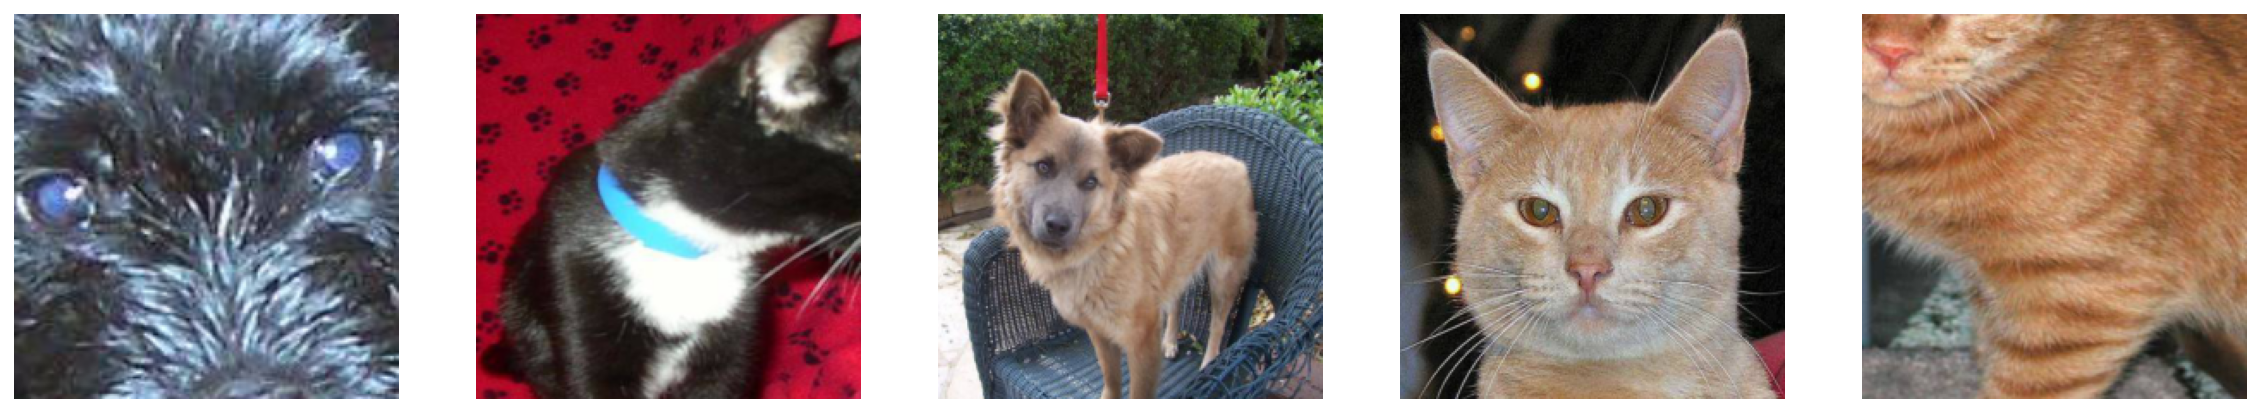

In [23]:
images, labels = get_random_images(5)
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20,20))
classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

Теперь давайте создадим нейронную сеть или сеть глубокого обучения для изучения взаимосвязей между признаками и каждым видом животного.

Принцип работы нейронной сети очень похож на работу мозга человека. Человеческий мозг состоит из нейронов или нервных клеток, которые передают и обрабатывают информацию, получаемую от органов чувств. Многие из нервных клеток объединены вместе, образуя нервные связи в нашем мозге. Нервные связи передают электрические импульсы от одного нейрона к следующему.

In [24]:
# Determine whether you're using a CPU or a GPU to build the deep learning network.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True) # ResNet 50 model

Нейронные сети имеют миллионы нейронов и нервных связей. Чтобы создать функциональную нейронную сеть, мы объединим все компоненты в два этапа:

 1. Создайте все нейроны.
 2. Соедините нейроны соответствующим образом (существуют тысячи способов соединения нейронов).

In [25]:
# Builds all the neurons.
for param in model.parameters():
    param.requires_grad = False

# The parameters of our deep learning model.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print('done')

done


Теперь, когда мы создали нейронную сеть и предоставили программу для определения различных признаков изображений, нам следует обучить программу. На этом шаге мы используем наши обучающие данные, чтобы наша программа очень точно классифицировала вид животного.

Переменная `epochs` сообщает программе, сколько раз следует искать связи в признаках. Изначально она имеет значение 5, но вы можете увеличить это число, чтобы повысить точность. Однако увеличение этого числа приводит к значительному повышению скорости выполнения кода.

In [26]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        print('Training step ', steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/5.. Train loss: 1.331.. Test loss: 0.308.. Test accuracy: 0.839
Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 1/5.. Train loss: 0.983.. Test loss: 1.453.. Test accuracy: 0.595
Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 1/5.. Train loss: 0.587.. Test loss: 0.195.. Test accuracy: 0.913
Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 1/5.. Train loss: 0.199.. Test loss: 0.178.. Test accuracy: 0.926
Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 1/5.. Train loss: 0.329.. Test loss: 0.152.. Test accuracy: 0.928
Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 1/5.. Train loss: 0.385.. Test loss: 0.217.. Test accuracy: 0.908
Training step  31
Training step  32
T

Training step  252
Training step  253
Training step  254
Training step  255
Epoch 2/5.. Train loss: 0.132.. Test loss: 0.151.. Test accuracy: 0.944
Training step  256
Training step  257
Training step  258
Training step  259
Training step  260
Epoch 2/5.. Train loss: 0.396.. Test loss: 0.363.. Test accuracy: 0.827
Training step  261
Training step  262
Training step  263
Training step  264
Training step  265
Epoch 2/5.. Train loss: 0.365.. Test loss: 0.148.. Test accuracy: 0.938
Training step  266
Training step  267
Training step  268
Training step  269
Training step  270
Epoch 2/5.. Train loss: 0.239.. Test loss: 0.179.. Test accuracy: 0.924
Training step  271
Training step  272
Training step  273
Training step  274
Training step  275
Epoch 2/5.. Train loss: 0.178.. Test loss: 0.117.. Test accuracy: 0.965
Training step  276
Training step  277
Training step  278
Training step  279
Training step  280
Epoch 2/5.. Train loss: 0.103.. Test loss: 0.130.. Test accuracy: 0.956
Training step  28

Training step  498
Training step  499
Training step  500
Epoch 4/5.. Train loss: 0.309.. Test loss: 0.157.. Test accuracy: 0.928
Training step  501
Training step  502
Training step  503
Training step  504
Training step  505
Epoch 4/5.. Train loss: 0.156.. Test loss: 0.197.. Test accuracy: 0.911
Training step  506
Training step  507
Training step  508
Training step  509
Training step  510
Epoch 4/5.. Train loss: 0.337.. Test loss: 0.112.. Test accuracy: 0.964
Training step  511
Training step  512
Training step  513
Training step  514
Training step  515
Epoch 4/5.. Train loss: 0.185.. Test loss: 0.209.. Test accuracy: 0.890
Training step  516
Training step  517
Training step  518
Training step  519
Training step  520
Epoch 4/5.. Train loss: 0.142.. Test loss: 0.177.. Test accuracy: 0.911
Training step  521
Training step  522
Training step  523
Training step  524
Training step  525
Epoch 4/5.. Train loss: 0.177.. Test loss: 0.148.. Test accuracy: 0.939
Training step  526
Training step  52

Training step  744
Training step  745
Epoch 5/5.. Train loss: 0.208.. Test loss: 0.135.. Test accuracy: 0.942
Training step  746
Training step  747
Training step  748
Training step  749
Training step  750
Epoch 5/5.. Train loss: 0.226.. Test loss: 0.105.. Test accuracy: 0.952


Основная часть ИИ — это степень точности при прогнозировании правильного результата. В нашем случае точность заключается в том, с какой долей вероятности компьютер должен правильно определить камень, показанный на изображении, как тип, который специалисты определили вручную. Точность 0,95 означает, что 95% изображений спрогнозированы правильно, а 5% — неправильно.

Следующий код вычисляет способность нашей системы ИИ точно классифицировать:

In [27]:
print(accuracy / len(testloader))

0.9523026315789473


Как видно, точность этой модели очень высока. Это именно то, что нам нужно, поскольку это означает, что модель является подходящей для выполнения прогнозов.

Несмотря на то, что показатель в 96% достаточно высок, вы можете выполнить еще несколько дополнительных действий для повышения точности.

 - Добавьте больше изображений для обучения моделей искусственного интеллекта.
 - Увеличьте эпоху (число итераций обучения для глубокого обучения).

Теперь, когда мы создали нейронную сеть и проверили точность, сохраните ее:

In [9]:
torch.save(model, 'cat_vs_dog.pth')

Давайте проверим работу нашей модели. Чтобы спрогнозировать тип камня на новом изображении, необходимо выполнить следующие действия.

1. Преобразуйте новое изображение в числа.
2. Преобразуйте изображение: обрежьте его и измените его размер до 224 × 224 пикселей.
3. Извлеките признаки и характеристики изображения.
4. Спрогнозируйте тип камня, показанного на изображении, с помощью взаимосвязей, изученных на шаге 2.

Следующий код загружает нейронную сеть:
```Python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('aerialmodel.pth')
```

In [28]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

Давайте выберем пять случайных изображений и посмотрим, сможет ли наша модель определить, к какому именно виду относится животное.

Следующий код получает пять случайных изображений и хранит их данные в переменных.

In [29]:
images, labels = get_random_images(8)

Этот код визуализирует новые изображения и добавляет заголовки, указывающие, какое животное было определен моделью по фотографии.

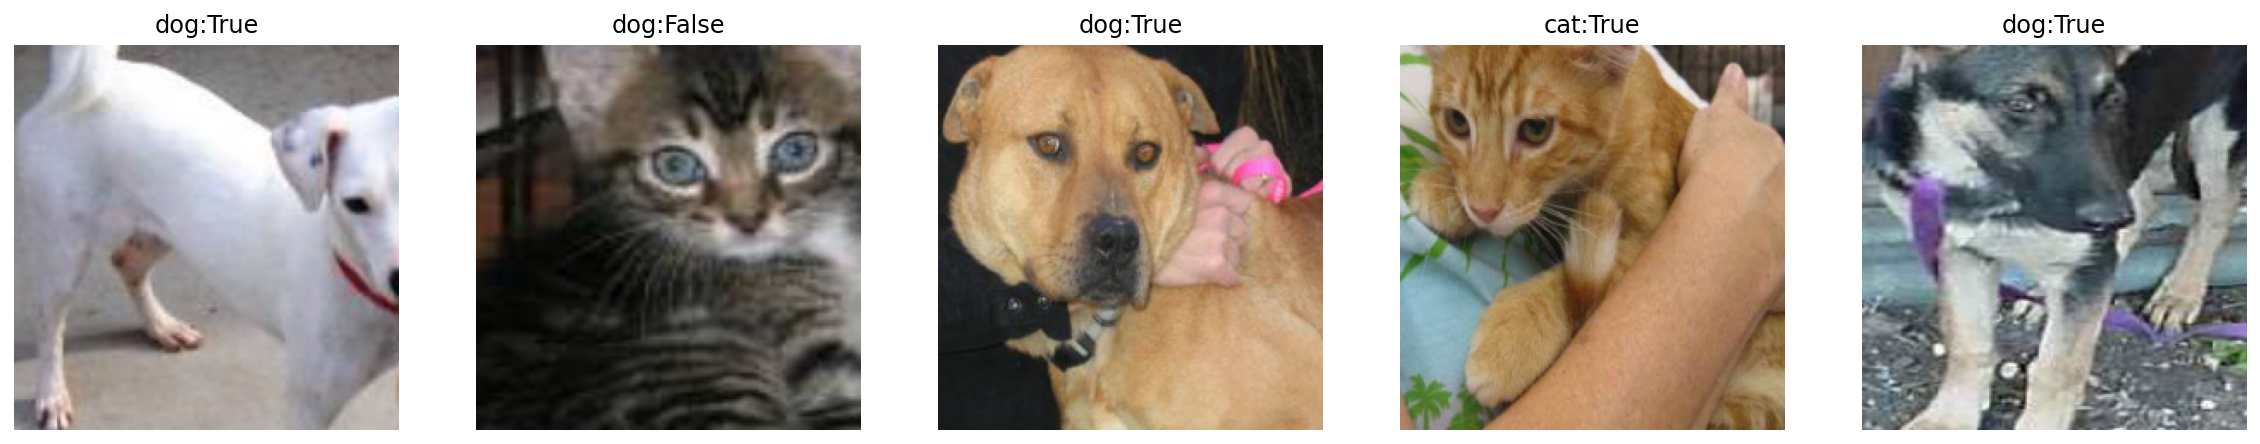

In [38]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20, 10))

classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

Примеры изображений помечаются как фактический вид: истина/ложь.

Истина и Ложь указывают, правильно ли наша система ИИ классифицировала животного на изображении.

In [55]:
def load_image(path: str, size: list = [200,200]) -> np.ndarray:
    img = load_img(path, target_size=size)
    return img

Проверим работу модели на фотографии, не присутствующей в исходном датасете.

cat


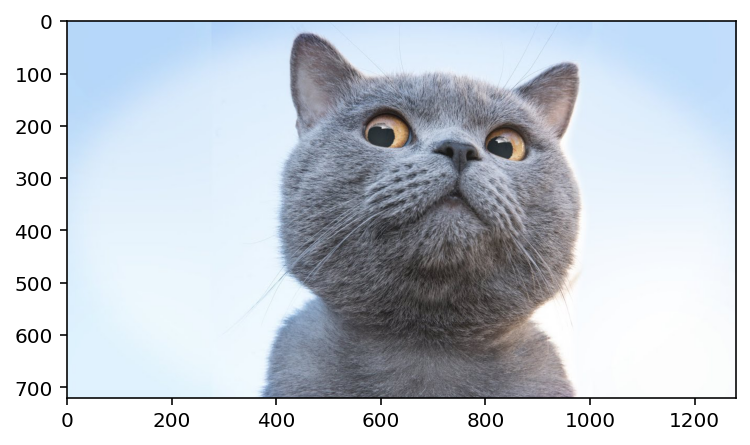

In [116]:
img_url = 'example.jpg'
print(classes[predict_image(load_image(img_url, [224,224]))])
plt.imshow(load_img(img_url, [250,250]));